In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.feature_selection import VarianceThreshold
from sklearn import preprocessing
from sklearn import cross_validation
from sklearn import linear_model
import warnings
import xgboost as xgb
import time
from sklearn.feature_extraction import DictVectorizer
from scipy import sparse
import pickle

import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
import pandas as pd
from pandas import Series

from datetime import datetime
%matplotlib inline
t = time.time()
#elapsed = (time.time() - t)/60

In [16]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [3]:
X=np.load('./mostrecentinput/nxtrain_standard_original0.npy')
X1= np.load('./mostrecentinput/nxtrain_standard_derived0.npy')
X2=pd.read_pickle("./mostrecentinput/time_series_derived_standard_train2.dat")
X3=pd.read_pickle("./mostrecentinput/time_series_original_standard_train2.dat")
X4=pd.read_pickle("./mostrecentinput/cat_numeric_th60_standard_train2.dat")
X5=pd.read_pickle("./mostrecentinput/cat_le_train2.dat") 
X=np.hstack((X,X1,X2,X3,X4,X5))

y=pickle.load(open("./mostrecentinput/ytrain2.dat","rb"))

In [32]:
class XGBoostClassifier():
    def __init__(self, num_boost_round=10, **params):
        self.clf = None
        self.num_boost_round = num_boost_round
        self.params = params
        self.params.update({'objective': 'binary:logistic'})
 
    def fit(self, X, y, num_boost_round=None):
        num_boost_round = num_boost_round or self.num_boost_round
        dtrain = xgb.DMatrix(X, label=y)
        self.clf = xgb.train(params=self.params, dtrain=dtrain, num_boost_round=num_boost_round)
        self.fscore = self.clf.get_fscore()
        
        bb=np.zeros(dtrain.num_col())

        for ftemp, vtemp in self.fscore.items():
            bb[int(ftemp[1:])]=vtemp
    
        bb=bb/float(bb.max())
        self.coef_= bb
        
    def predict(self, X):
        num2label = {i: label for label, i in self.label2num.items()}
        Y = self.predict_proba(X)
        y = np.argmax(Y, axis=1)
        return np.array([num2label[i] for i in y])
 
    def predict_proba(self, X):
        dtest = xgb.DMatrix(X)
        return self.clf.predict(dtest)
 
    def score(self, X, y):
        Y = self.predict_proba(X)
        return 1 / self.logloss(y, Y)
 
    def get_params(self, deep=True):
        return self.params
 
    def set_params(self, **params):
        if 'num_boost_round' in params:
            self.num_boost_round = params.pop('num_boost_round')
        if 'objective' in params:
            del params['objective']
        self.params.update(params)
        return self
    
    
    def logloss(self,y_true, Y_pred):
        label2num = dict((name, i) for i, name in enumerate(sorted(set(y_true))))
        return -1 * sum(math.log(y[label2num[label]]) if y[label2num[label]] > 0 else -np.inf \
                        for y, label in zip(Y_pred, y_true)) / len(Y_pred)
    
    

In [5]:
def scorer(estimator, X_test, y_test):
    preds_cv = estimator.predict_proba(X_test)
    roc_auc=metrics.roc_auc_score(y_test, preds_cv)
    return roc_auc

In [6]:
xgbclassifier = XGBoostClassifier(num_boost_round=50)
rfecv = RFECV(estimator=xgbclassifier, step=40, cv=2, scoring=scorer, verbose=2)
selector=rfecv.fit(X, y)


Fitting estimator with 1759 features.
Fitting estimator with 1719 features.
Fitting estimator with 1679 features.
Fitting estimator with 1639 features.
Fitting estimator with 1599 features.
Fitting estimator with 1559 features.
Fitting estimator with 1519 features.
Fitting estimator with 1479 features.
Fitting estimator with 1439 features.
Fitting estimator with 1399 features.
Fitting estimator with 1359 features.
Fitting estimator with 1319 features.
Fitting estimator with 1279 features.
Fitting estimator with 1239 features.
Fitting estimator with 1199 features.
Fitting estimator with 1159 features.
Fitting estimator with 1119 features.
Fitting estimator with 1079 features.
Fitting estimator with 1039 features.
Fitting estimator with 999 features.
Fitting estimator with 959 features.
Fitting estimator with 919 features.
Fitting estimator with 879 features.
Fitting estimator with 839 features.
Fitting estimator with 799 features.
Fitting estimator with 759 features.
Fitting estimator w

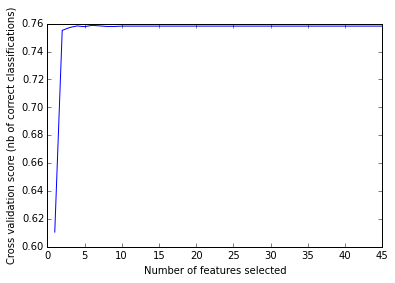

In [30]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.show()


In [46]:
Xselect=X[:,selector.support_]

skf = cross_validation.StratifiedKFold(y, n_folds=2) # K-fold cv splitting
for train0, cv0 in skf:
    train, cv = train0, cv0
    break
    
    
dtrain = xgb.DMatrix(Xselect[train,:], label=y[train])
dtest = xgb.DMatrix(Xselect[cv,:], label=y[cv])

params = {'max_depth':14, 
             'eta':0.01, 
             'objective':'binary:logistic', 
             'subsample':0.6,
             'colsample_bytree':0.6,
             'eval_metric': 'auc'}

clf = xgb.train(params=params,dtrain=dtrain, num_boost_round=1000)
preds_cv = clf.predict(dtest)
AUC1=metrics.roc_auc_score(y[cv], preds_cv)
print(AUC1)


0.774193072089


##Feature selection for Scikit learn gradient boosting 

In [ ]:
from sklearn import ensemble
class GradientBoostingClassifierWithCoef(ensemble.GradientBoostingClassifier):
    def fit(self, *args, **kwargs):
        super(GradientBoostingClassifierWithCoef, self).fit(*args, **kwargs)
        self.coef_ = self.feature_importances_
        print(self.feature_importances_)
        
original_params = {'n_estimators': 40, 'max_leaf_nodes': 4, 'max_depth': None, 'random_state': 2,
                   'min_samples_split': 5}

params=original_params
GB = GradientBoostingClassifierWithCoef(**params)
rfecv = RFECV(estimator=GB, step=100, cv=2, scoring='roc_auc', verbose=1)
selector=rfecv.fit(X, y)

Xselect=X[:,selector.support_]
clf = ensemble.GradientBoostingClassifier(**params)
skf = cross_validation.StratifiedKFold(y, n_folds=2) # K-fold cv splitting

for train0, cv0 in skf:
    train, cv = train0, cv0
    break

MODEL = clf.fit(Xselect[train,:], y[train])
Xselect[train,:].shape
AUC1=scorer(MODEL, Xselect[cv,:], y[cv])
str1=time.strftime("%b%d%Y%H%M%S", time.localtime())
filename='SDGRF_'  +  str1 + '_AUC_' + str(AUC1) + '.p'
np.arange(X.shape[1])[selector.support_].dump(filename)
print(Xselect[train,:].shape)

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.show()

## Feature selection for Scikit learn Random Forest

In [ ]:
class RandomForestClassifierWithCoef(RandomForestClassifier):
    def fit(self, *args, **kwargs):
        super(RandomForestClassifierWithCoef, self).fit(*args, **kwargs)
        self.coef_ = self.feature_importances_
#-----------------------------------------------
rf = RandomForestClassifierWithCoef(n_estimators=50, min_samples_leaf=5, n_jobs=-1)
rfecv = RFECV(estimator=rf, step=40, cv=2, scoring='roc_auc', verbose=0)
selector=rfecv.fit(X, y)

Xselect=X[:,selector.support_]
clf = RandomForestClassifier(n_estimators=50, min_samples_leaf=5, n_jobs=-1)
skf = cross_validation.StratifiedKFold(y, n_folds=2) # K-fold cv splitting
for train0, cv0 in skf:
    train, cv = train0, cv0
    break

MODEL = clf.fit(Xselect[train,:], y[train])
Xselect[train,:].shape
AUC1=scorer(MODEL, Xselect[cv,:], y[cv])
str1=time.strftime("%b%d%Y%H%M%S", time.localtime())
filename='SDGRF_'  +  str1 + '_AUC_' + str(AUC1) + '.p'
np.arange(X.shape[1])[selector.support_].dump(filename)
print(Xselect[train,:].shape)

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.show()